###### Для части 1.

In [1]:
import sqlite3

###### Для части 2.

In [2]:
from collections import defaultdict, Counter
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
db = sqlite3.connect('../ALLP.db')
cur = db.cursor()

### 1. Как посмотреть вхождения в корпусе

In [4]:
cur.execute('''SELECT author.band, song.songname, song.year, token.id, token.song_id, token.line, token.token, token.lem, token.in_sent FROM token
            JOIN song ON song.id = token.song_id
        JOIN author ON author.id = song.author_id''')
tokens = cur.fetchall()

In [5]:
tokens[10]

('Loboda', 'Твои глаза', 2016, 1557, 18, 1, 'на', 'на', 3)

In [6]:
def checklem(lem, tokens=tokens):
    tdictlist = []
    for token in tokens:
        tok = {}
        tok['artist']=token[0]
        tok['songname']=token[1]
        tok['year']=token[2]
        tok['id']=token[3]
        tok['song_id']=token[4]
        tok['line']=token[5]
        tok['token']=token[6]
        tok['lem']=token[7]
        tok['in_sent']=token[8]
        tdictlist.append(tok)
        
    violence = []
    for item in tdictlist:
        if item['lem']==lem:
            s_id = item['song_id']
            string = []
            for token in tdictlist:
                if token['song_id']==s_id:
                    if token['line']==item['line']:
                        string.append(token['token'])
            viol_list = []
            viol_list.append(item['artist'])
            viol_list.append(item['songname'])
            viol_list.append(item['year'])
            viol_list.append(' '.join([item for item in string]))
            violence.append(viol_list)
    df = pd.DataFrame(violence, columns=['artist', 'songname', 'year', 'lyric'])
    return df

In [7]:
may = checklem('май')

In [8]:
may

,artist,songname,year,lyric
0,Monatik,Вечность,2016,В голове моей нужен май
1,Иван Дорн,Стыцамен,2011,Самая люби муз мая люби грает
2,Иван Дорн,Стыцамен,2011,Самая люби муз мая люби грает
3,монеточка,90,2018,Ведь только Ласковый Май пел по радио
4,FACE,Лиза,2017,Май среди январей
5,Каста,Ды-ды-дым,2008,Так это ж май был
6,МакSим,Мой рай,2007,В предметах черного цвета и слышать в голосе май
7,МакSим,Птицы,2009,Где цветёт сирень где кружится май
8,АукцЫон,Зима,1991,Лето излечит осень научит май
9,Винтаж,"Город, где сбываются мечты",2015,И мы вдохнем с тобою вечный май


### 2. Получаем данные о семантике при помощи USAS

#### 0. Подготовка

[Подробнее](http://ucrel.lancs.ac.uk/publications/MudrayaEtAlCL2006Russian.pdf) [Список тегов pdf](http://ucrel.lancs.ac.uk/usas/USASSemanticTagsetRussian.pdf) [Список тегов txt](http://ucrel.lancs.ac.uk/usas/semtag_ru.txt) 
[Словарь](http://ucrel.lancs.ac.uk/usas/semtag_ru.txt)<br>
Также <i>см.репозиторий</i>

Выгружаем токены

In [9]:
cur.execute('''SELECT author.band, token.token, token.lem, token.in_sent
        FROM token
        JOIN song ON song.id = token.song_id
        JOIN author ON author.id = song.author_id''')
sid = cur.fetchall()

Выгружаем все леммы, чтобы сравнивать леммы из корпуса и леммы из разметки

In [10]:
cur.execute('SELECT pos, lem FROM token')
lems = cur.fetchall()

Выгружаем словарь с семантической разметкой

In [11]:
with open('../semantic_lexicon_rus.usas', encoding='utf-8') as f:
    text = f.read()
llines = text.splitlines()
words = llines[160:-2]  # убираем числа и последние пустые строки
word_dict = defaultdict(str)
for line in words:
    word, pos, tag = line.split('\t')
    word_dict[word] = tag

1. fromcodestocounter<br>
codelist - строка, в которой указаны коды, которые нам нужны. <br>
excllist - список кодов, которые нам не нужны. Используется для снятия омонимии <br>
word_dict - словарь для каждого слова из списка usas с его разметкой <br>
lems - леммы из корпуса

acccepted - это части речи, которые вы принимаете в обработку

In [12]:
accepted = ['S']

In [13]:
def fromcodestocounter(codelist, excllist, word_dict, lems):
    lines = codelist.splitlines()
    codes = []
    for line in lines:
        code, __ = line.strip('\t').split('\t')
        codes.append(code)
    phys_list = []
    for key in word_dict:
        keys = re.split(' |/', word_dict[key])
        ch = 0
        excl = 0
        for code in codes:
            for ke in keys:
                if ke == code:
                    ch+=1
        for ke in keys:
            if ke in excllist:
                excl+=1
        if excl == 0:        
            if ch > 0:
                 phys_list.append(key)
    routine = defaultdict(int)
    for item in lems:
        if item[0] in accepted:
            if item[1] in phys_list:
                routine[item[1]]+=1
    ddd = Counter(routine)
    return ddd.most_common()

In [14]:
foodcodes = '''F1	Пища
F1+	Изобилие еды
F1-	Нехватка еды
F2	Напитки и алкоголь'''

In [15]:
food = fromcodestocounter(foodcodes, ['B1', 'W3', 'B3'], word_dict, lems)

In [16]:
food

[('птица', 79),
 ('вино', 63),
 ('водка', 28),
 ('бар', 27),
 ('ресторан', 19),
 ('кухня', 19),
 ('хлеб', 18),
 ('кофе', 16),
 ('завтрак', 13),
 ('еда', 13),
 ('пост', 13),
 ('рыба', 13),
 ('масло', 12),
 ('мед', 12),
 ('пиво', 11),
 ('ужин', 11),
 ('коньяк', 11),
 ('алкоголь', 10),
 ('коктейль', 10),
 ('яблоко', 10),
 ('соль', 10),
 ('блин', 10),
 ('метр', 9),
 ('сахар', 8),
 ('гриб', 8),
 ('джин', 8),
 ('шоколад', 7),
 ('посуда', 7),
 ('текила', 6),
 ('обед', 6),
 ('мак', 6),
 ('официант', 6),
 ('порция', 6),
 ('торт', 6),
 ('банан', 6),
 ('сыр', 6),
 ('конфета', 6),
 ('блюдо', 6),
 ('кафе', 5),
 ('чипсы', 5),
 ('сковородка', 5),
 ('пудинг', 5),
 ('щи', 5),
 ('каша', 5),
 ('тарелка', 5),
 ('тесто', 5),
 ('плита', 4),
 ('спирт', 4),
 ('рис', 4),
 ('кокос', 4),
 ('масса', 4),
 ('зерно', 4),
 ('печь', 4),
 ('напиток', 4),
 ('баня', 4),
 ('конфетка', 4),
 ('котлета', 4),
 ('ром', 4),
 ('мука', 4),
 ('тост', 3),
 ('суп', 3),
 ('лимонад', 3),
 ('дичь', 3),
 ('портвейн', 3),
 ('леденец', 3)

2. valtocount - функция, считает вхождения по исполнителям <br>
2.1 most_com - функция, которая превращает defaultdict в counter, отсортированный от большего к меньшему

In [17]:
def most_com(defdict):
    adict = Counter(defdict)
    return adict.most_common()

In [18]:
def valtocount(val, defdict, sid):
    for item in sid:
        artist = item[0]
        token = item[1]
        lem = item[2]
        in_sent = item[3]
        if lem in val:
            defdict[artist] +=1
    return most_com(defdict)

In [19]:
food_v = [item[0] for item in food]
artfood = valtocount(food_v, defaultdict(int), sid)

3. namesfigs<br>
acounter - каунтер со всеми полученными значениями <br>
quantity - слова, чье количество вхождений больше qunatity, вы получите на графике

In [20]:
def namesfigs(acounter, quantity):
    names = []
    figures = []
    for it in acounter:
        if it[1]>quantity:
            names.append(it[0])
            figures.append(it[1])
    return names, figures

4. функция, которая строит график для исполнителей. на вход подается словарь с вхождениями у исполнителей

In [21]:
def buildgraph(names, figures, savename, title):
    plt.figure(figsize=(15,15))
    rgb = (round(random.random(), 1), round(random.random(), 1), round(random.random(), 1))
    plt.rcdefaults()
    fig, ax = plt.subplots()
    
    # Example data
    y_pos = np.arange(len(names))
    performance = figures
    
    ax.barh(y_pos, performance, align='center', color=rgb)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names, fontsize=8)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(title)
    ax.set_xlabel('Абсолютное количество')
    
    for i, v in enumerate(performance):
      #  ax.text(v + 3, i + .25, str(v), color='blue', fontsize=8)
        ax.text(v+0.1, i + .25, str(v), color='blue', fontsize=6)
    titl = f'{savename}.png'
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(titl, dpi=300, bbox_inches = "tight")

5. Функция, которая задает альтернативный выбор между видами графиков. Варьируется подаваемый словарь и цифра. <br>
1 - для исполнителей <br>
2 (не 1) - для лексики

In [22]:
def countograph(acounter, quantity, savename, title, typ):
    names, figures = namesfigs(acounter, quantity)
    if typ == 1:  # для топа исполнителей
        graph = buildgraph(names, figures, savename, title)
    else:  # для топа лексики
        graph = build2(names, figures, savename, title)

<Figure size 1080x1080 with 0 Axes>

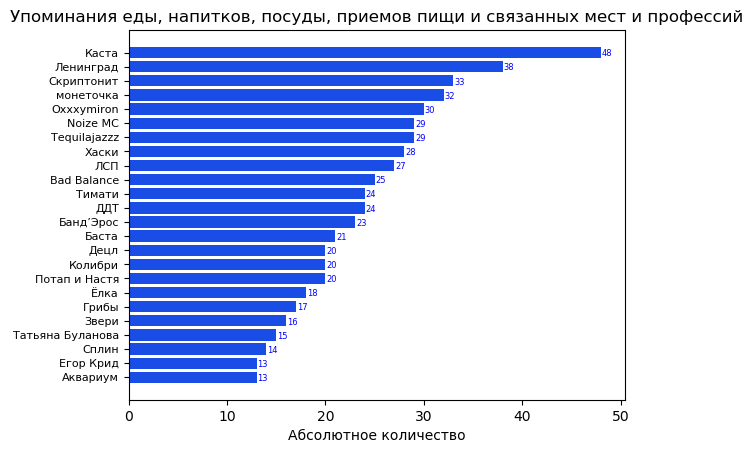

In [23]:
foodg = countograph(artfood, 12, 'artfood', r'Упоминания еды, напитков, посуды, приемов пищи и связанных мест и профессий', 1)

5. функция, которая строит график для лексики

In [24]:
def build2(values, freqs, savename, title):
    plt.figure(figsize=(15,15)) 
    xs = values
    ys = [freq/169257 for freq in freqs]
    plt.plot(xs,ys)
    
    for x,y in zip(xs,ys):
    
        label = int(y*169257)
    
        plt.annotate(label,
                     (x,y),
                     textcoords="offset points", # how to position the text
                     xytext=(0,6), # distance from text to points (x,y)
                     ha='center',
                    rotation=30) # horizontal alignment can be left, right or center
        
    
    
    plt.xticks(rotation=60, fontsize=12) 
    plt.title(title, fontsize=14)
    
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f'{savename}.png', dpi=300, bbox_inches = "tight")

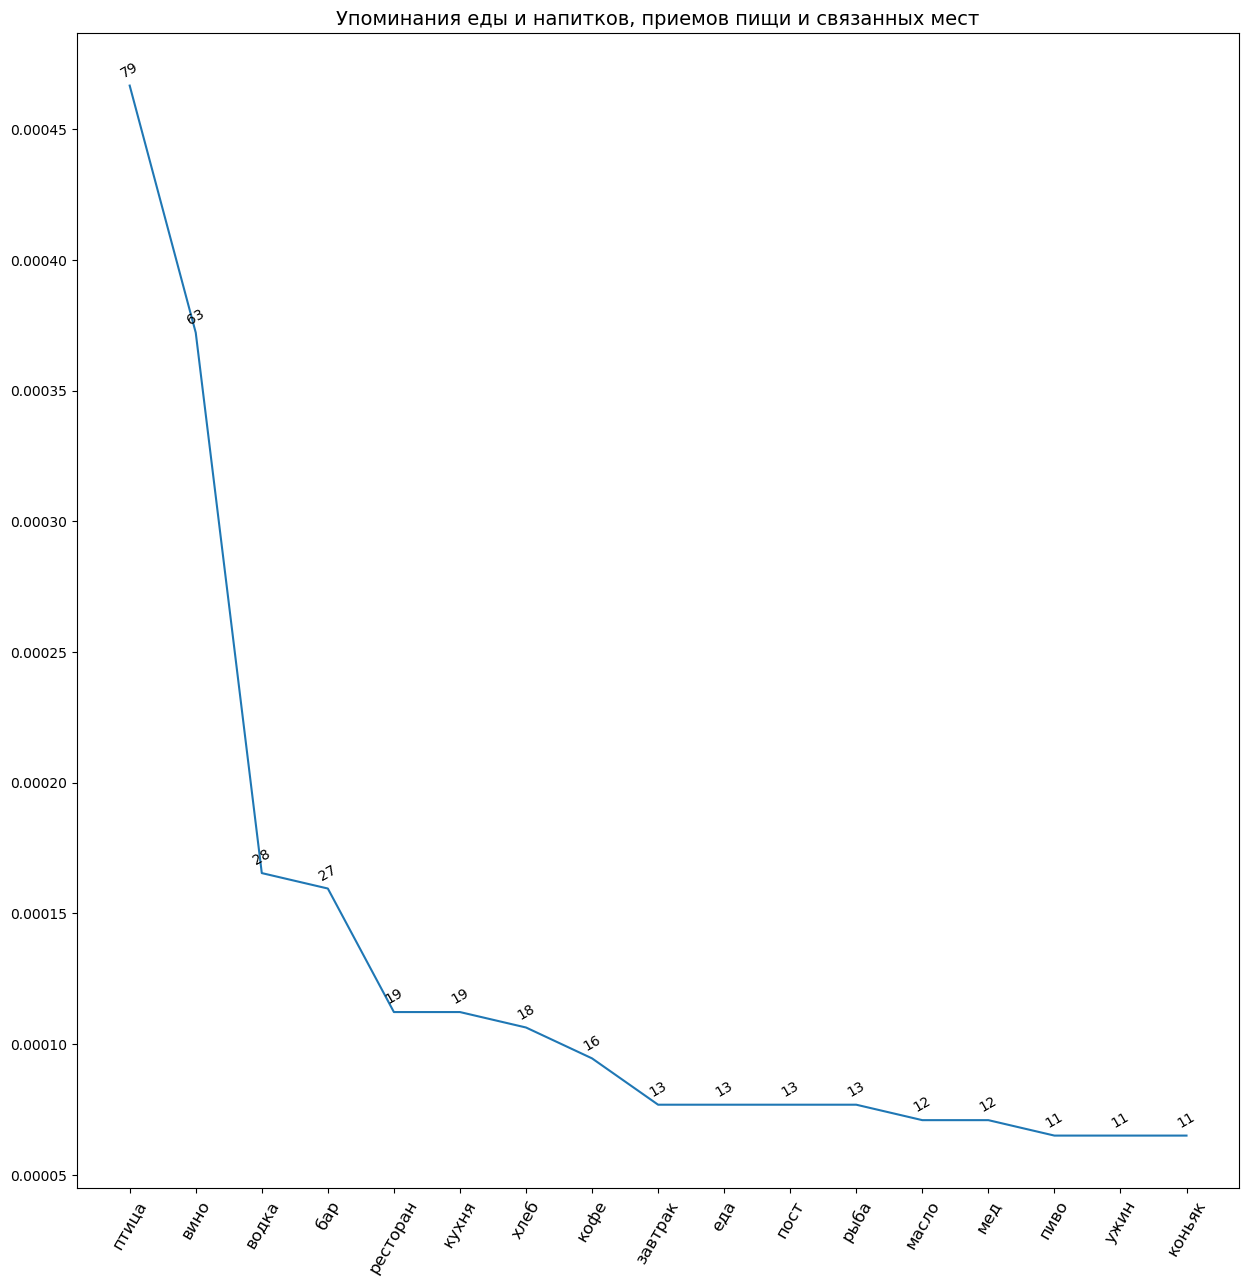

<Figure size 640x480 with 0 Axes>

In [25]:
foodvg = countograph(food, 10, 'dish', r'Упоминания еды и напитков, приемов пищи и связанных мест', 2)

In [26]:
db.close()